# MNIST Digit Recognition with higher accuracy using Elastic Distortion

## Imports

In [1]:
import time
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.nn.functional as F

import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader, TensorDataset

import torchvision
from torchvision import transforms
from torchvision import datasets, models, transforms

from torch.utils.tensorboard import SummaryWriter

from PIL import Image
from tempfile import TemporaryDirectory

writer = SummaryWriter('/kaggle/working/logs')
# %load_ext tensorboard.notebook
# %tensorboard --logdir /kaggle/working/logs

device = torch.device('cpu')
device

device(type='cpu')

In [2]:
# PATH_TO_DATA = 'Datasets/'
PATH_TO_DATA = '/kaggle/input/digit-recognizer/'
train_data = pd.read_csv(os.path.join(PATH_TO_DATA, 'train.csv'))
test_data = pd.read_csv(os.path.join(PATH_TO_DATA, 'test.csv'))

train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42000 entries, 0 to 41999
Columns: 785 entries, label to pixel783
dtypes: int64(785)
memory usage: 251.5 MB


In [3]:
train_data.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
train_data.shape, test_data.shape

((42000, 785), (28000, 784))

## Preparing Dataset

In [5]:
X = train_data.values[:, 1:]
y = train_data.values[:, 0]
X_test = test_data.values
X.shape, y.shape

((42000, 784), (42000,))

In [6]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((33600, 784), (8400, 784), (33600,), (8400,))

In [7]:
class MNISTDataset(Dataset):
    def __init__(self, X, y, transform=None):
        self.n_samples = X.shape[0]
        X = X.reshape(-1, 1, 28, 28) / 255.
        self.x_data = torch.from_numpy(X.astype(np.float32))
        self.y_data = torch.from_numpy(y)
        
        self.transform = transform
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, item):
        image, label = self.x_data[item], self.y_data[item]
        
        if self.transform is not None:
            image = self.transform(image)
            
        return image, label

In [8]:
class MNISTDataset_test(Dataset):
    def __init__(self, X, transform=None):
        self.n_samples = X.shape[0]
        X = X.reshape(-1, 1, 28, 28) / 255.
        self.x_data = torch.from_numpy(X.astype(np.float32))
        
        self.transform = transform
        
    def __len__(self):
        return self.n_samples
    
    def __getitem__(self, item):
        sample = self.x_data[item]
        
        if self.transform is not None:
            sample = self.transform(sample)
            
        return sample

## Transformations

In [9]:
from scipy.ndimage.filters import gaussian_filter
from scipy.ndimage.interpolation import map_coordinates

def elastic_transform(image, alpha_range, sigma, random_state=None):
    """
    # Arguments
       image: Numpy array with shape (height, width, channels). 
       alpha_range: Float for fixed value or [lower, upper] for random value from uniform distribution.
           Controls intensity of deformation.
       sigma: Float, sigma of gaussian filter that smooths the displacement fields.
       random_state: `numpy.random.RandomState` object for generating displacement fields.
    """

    if random_state is None:
        random_state = np.random.RandomState(None)
    
    if np.isscalar(alpha_range):
        alpha = alpha_range
    else:
        alpha = np.random.uniform(low=alpha_range[0], high=alpha_range[1])
    
    shape = image.shape
    dx = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    dy = gaussian_filter((random_state.rand(*shape) * 2 - 1), sigma) * alpha
    
    x, y, z = np.meshgrid(np.arange(shape[0]), np.arange(shape[1]), np.arange(shape[2]), indexing='ij')
    indices = np.reshape(x + dx, (-1, 1)), np.reshape(y + dy, (-1, 1)), np.reshape(z, (-1, 1))
    
    return torch.from_numpy(map_coordinates(image, indices, order=1, mode='reflect').reshape(1, 28, 28)).to(device, torch.float32)

/tmp/ipykernel_20/1988255430.py:1: DeprecationWarning: Please use `gaussian_filter` from the `scipy.ndimage` namespace, the `scipy.ndimage.filters` namespace is deprecated.
  from scipy.ndimage.filters import gaussian_filter
/tmp/ipykernel_20/1988255430.py:2: DeprecationWarning: Please use `map_coordinates` from the `scipy.ndimage` namespace, the `scipy.ndimage.interpolation` namespace is deprecated.
  from scipy.ndimage.interpolation import map_coordinates


In [10]:
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(10),  # Randomly rotate by up to 10 degrees
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1)),  # Randomly zoom and shift
    transforms.Lambda(lambda x: elastic_transform(np.array(x).reshape(28, 28, 1), alpha_range=[0, 10], sigma=3)),
#     transforms.ToTensor()
])

In [11]:
batch_size = 128
num_classes = 10 

In [12]:
train_dataset = MNISTDataset(X_train, y_train)
val_dataset = MNISTDataset(X_val, y_val)

full_train_dataset = MNISTDataset(X, y)
test_dataset = MNISTDataset_test(X_test)

In [13]:
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=True)

full_train_loader = DataLoader(dataset=full_train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

In [14]:
images, labels = next(iter(train_loader))
images.shape, labels.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128]))

## Training Models

In [15]:
def train_model(model, criterion, optimizer, num_epochs, train_loader=train_loader, val_loader=None, scheduler=None, tag='train'):
    steps_per_epoch = len(train_loader)
    for epoch in range(num_epochs):

        running_loss = 0.0
        running_corrects = 0
        running_corrects_val = 0
            
        for i, (images, labels) in enumerate(train_loader):
            images = images.to(device)
            labels = labels.to(device)            
            
            optimizer.zero_grad()
            output = model(images)
            loss = criterion(output, labels)
            loss.backward()
            optimizer.step()
            
            with torch.no_grad():
                _, predictions = torch.max(output, 1)
                corrects = (predictions == labels).sum().item()
                running_corrects += corrects
                
                running_loss += loss.item()
                
            writer.add_scalar(f'{tag}_loss', loss, epoch*steps_per_epoch + i)
            writer.add_scalar(f'{tag}_accuracy', corrects/labels.shape[0], epoch*steps_per_epoch + i)
        
        epoch_loss = running_loss / steps_per_epoch
        epoch_acc = running_corrects*100/len(train_loader)/batch_size

        print(f'epoch {epoch+1}/{num_epochs}, loss {epoch_loss:.4f}, training accuracy {epoch_acc:.2f}%', end='')
                
        if val_loader is not None:
            for i, (images, labels) in enumerate(val_loader):
                images = images.to(device)
                labels = labels.to(device)
                
                with torch.no_grad():
                    output = model(images)
                    _, predictions = torch.max(output, 1)
                    corrects = (predictions == labels).sum().item()
                    running_corrects_val += corrects
                    
                writer.add_scalar('val_accuracy', corrects/labels.shape[0], epoch*len(val_loader) + i)
                    
            epoch_val_acc = running_corrects_val*100/len(val_loader)/batch_size
            print(f', validation accuracy {epoch_val_acc:.2f}%')
        else:
            print()
                
        if scheduler is not None:
            scheduler.step()
            
    writer.flush()
    writer.close()
            

In [16]:
from sklearn.metrics import classification_report, confusion_matrix

def validate_model(model, val_loader=val_loader):
    
    y_true = []
    y_pred = []
    
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            
            output = model(images) 
            _, predictions = torch.max(output, 1)
            
            y_true.extend(labels.cpu().tolist())
            y_pred.extend(predictions.cpu().tolist())
            
    print(classification_report(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred, normalize='true')
    sns.heatmap(cm)

In [17]:
def test_model(model, test_loader=test_loader, y_true=None):
    
    y_pred = []
    
    with torch.no_grad():
        for images in test_loader:
            images = images.to(device)
            
            output = model(images) 
            _, predictions = torch.max(output, 1)
            
            y_pred.extend(predictions.cpu().tolist())
        
    if y_true is not None:
        print(classification_report(y_true, y_pred))
        cm = confusion_matrix(y_true, y_pred, normalize='true')
        sns.heatmap(cm, annot=True)
    else:
        return y_pred 

In [18]:
class LinearNet(nn.Module):
    def __init__(self, in_features=784):
        super().__init__()
        self.fc = nn.Linear(in_features, num_classes)
        
    def forward(self, x):
        x = x.flatten(start_dim=1)
        x = self.fc(x)
        return x
    
class LinearNet2(nn.Module):
    def __init__(self, in_features=784, hidden_layer=256):
        super().__init__()
        self.fc = nn.Sequential(
            nn.Linear(in_features, hidden_layer),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            nn.Linear(hidden_layer, hidden_layer),
            nn.BatchNorm1d(hidden_layer),
            nn.ReLU(),
            nn.Linear(hidden_layer, num_classes)
        )
        
    def forward(self, x):
        x = x.flatten(start_dim=1)
        return self.fc(x)
    
class ConvNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
        )

    def forward(self, x):
        return self.fc(x)

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            nn.LazyConv2d(6, kernel_size=5, padding=2), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.LazyConv2d(16, kernel_size=5), nn.ReLU(),
            nn.AvgPool2d(kernel_size=2, stride=2),
            nn.Flatten(),
            nn.LazyLinear(128), nn.ReLU(),
            nn.LazyLinear(64), nn.ReLU(),
            nn.LazyLinear(num_classes))
        
    def forward(self, x):
        return self.net(x)


## Comparing Results of Different Models and optimizers

In [19]:
lr = 4e-3
epochs = 15
# model = LinearNet2().to(device)
model = LeNet().to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_model(model, criterion, optimizer, num_epochs=epochs, val_loader=val_loader)

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch 1/15, loss 0.3733, training accuracy 88.09%, validation accuracy 95.92%
epoch 2/15, loss 0.1006, training accuracy 96.72%, validation accuracy 96.93%
epoch 3/15, loss 0.0692, training accuracy 97.75%, validation accuracy 97.32%
epoch 4/15, loss 0.0543, training accuracy 98.05%, validation accuracy 97.60%
epoch 5/15, loss 0.0460, training accuracy 98.42%, validation accuracy 97.70%
epoch 6/15, loss 0.0362, training accuracy 98.67%, validation accuracy 97.63%
epoch 7/15, loss 0.0344, training accuracy 98.70%, validation accuracy 97.63%
epoch 8/15, loss 0.0271, training accuracy 99.00%, validation accuracy 98.04%
epoch 9/15, loss 0.0236, training accuracy 99.03%, validation accuracy 97.66%
epoch 10/15, loss 0.0222, training accuracy 99.12%, validation accuracy 97.94%
epoch 11/15, loss 0.0238, training accuracy 99.05%, validation accuracy 98.14%
epoch 12/15, loss 0.0192, training accuracy 99.21%, validation accuracy 97.79%
epoch 13/15, loss 0.0164, training accuracy 99.28%, validatio

              precision    recall  f1-score   support

           0       0.99      0.99      0.99       816
           1       1.00      0.99      0.99       909
           2       0.99      0.98      0.98       846
           3       0.99      0.98      0.99       937
           4       0.98      0.99      0.99       839
           5       0.99      0.98      0.98       702
           6       0.98      0.99      0.99       785
           7       0.97      0.99      0.98       893
           8       0.98      0.99      0.98       835
           9       0.98      0.98      0.98       838

    accuracy                           0.99      8400
   macro avg       0.99      0.99      0.99      8400
weighted avg       0.99      0.99      0.99      8400



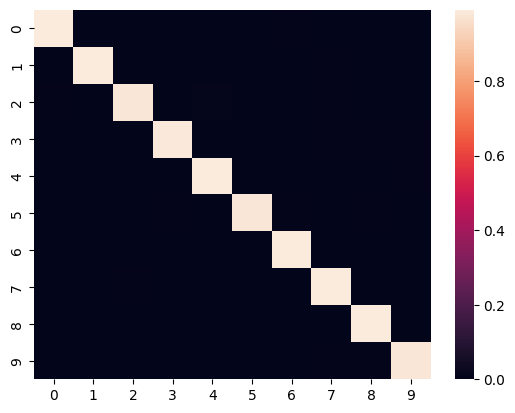

In [20]:
validate_model(model)

## Final Training and Submission

In [21]:
# best_model = LinearNet2().to(device)
best_model = LeNet().to(device)
optimizer = optim.Adam(best_model.parameters(), lr=lr)
criterion = nn.CrossEntropyLoss()

train_model(best_model, criterion, optimizer, num_epochs=epochs, train_loader=full_train_loader, tag='final_training')

/opt/conda/lib/python3.10/site-packages/torch/nn/modules/lazy.py:180: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


epoch 1/15, loss 0.3928, training accuracy 86.77%
epoch 2/15, loss 0.0866, training accuracy 97.04%
epoch 3/15, loss 0.0595, training accuracy 97.91%
epoch 4/15, loss 0.0482, training accuracy 98.27%
epoch 5/15, loss 0.0386, training accuracy 98.55%
epoch 6/15, loss 0.0375, training accuracy 98.53%
epoch 7/15, loss 0.0330, training accuracy 98.62%
epoch 8/15, loss 0.0225, training accuracy 99.05%
epoch 9/15, loss 0.0222, training accuracy 99.06%
epoch 10/15, loss 0.0255, training accuracy 98.90%
epoch 11/15, loss 0.0191, training accuracy 99.11%
epoch 12/15, loss 0.0179, training accuracy 99.11%
epoch 13/15, loss 0.0177, training accuracy 99.16%
epoch 14/15, loss 0.0144, training accuracy 99.28%
epoch 15/15, loss 0.0128, training accuracy 99.34%


In [22]:
def submit_prediction(y_pred, name='submission'):
    submission = pd.DataFrame({'ImageId': range(1, len(y_pred)+1), 'Label': y_pred})
    submission.to_csv(f'/kaggle/working/{name}.csv', index=False)

In [23]:
y_pred = test_model(best_model)
submit_prediction(y_pred)